# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [1]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  1117k      0  0:01:22  0:01:22 --:--:-- 1933k:09:49  0:00:20  0:09:29 66421
total 56
-rw-r--r--     1 smrack  staff      0 Jun 29 09:20 README.md
-rw-r--r--@    1 smrack  staff  28475 Jun 30 15:56 image_denoising.ipynb
drwx------  1087 smrack  staff  34784 Jun  9 15:06 paintings
drwxr-xr-x     9 smrack  staff    288 Jun 30 15:54 tests


In [2]:
import glob

In [3]:
dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths;

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

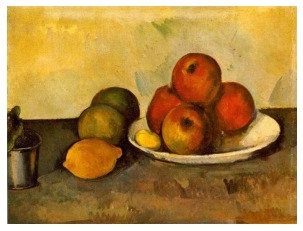

In [5]:
img_path_54 = dataset_paths[54]
img_54 = Image.open(img_path_54)
plt.imshow(img_54)
plt.axis('off');

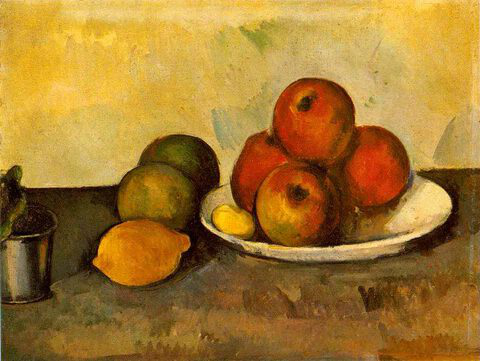

In [6]:
img_54

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [7]:
plt.imread(img_path_54).shape, plt.imread(img_path_54).ndim

((361, 480, 3), 3)

In [8]:
img_shape = plt.imread(img_path_54).shape
img_dim = plt.imread(img_path_54).ndim

❓ **What was in the image above?**

In [9]:
img_shape = img_shape
img_dim = img_dim

# Uncomment the correct answer

#is_portrait = True
is_portrait = False

is_colored_image = True
#is_colored_image = False

In [10]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [11]:
import os
import numpy as np
import pandas as pd

In [12]:
dataset_images = [plt.imread(img_path) for img_path in dataset_paths]

In [13]:
len(dataset_images)

1085

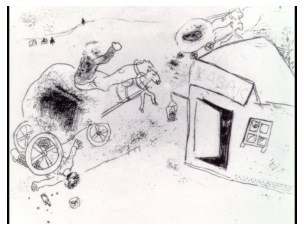

In [14]:
plt.imshow(dataset_images[4])
plt.axis('off');

### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

In [15]:
from tqdm import tqdm

In [16]:
same_dim = [1 if x.ndim==3 else 0 for x in tqdm(dataset_images)]

100%|██████████| 1085/1085 [00:00<00:00, 737094.24it/s]


In [17]:
np.sum(same_dim)/len(same_dim)

# We notice that only about 93% of the images have dimension 3, they are 3-colored images.
# The others are black and white images.

0.9336405529953917

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [18]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in tqdm(dataset_images)]
set([x.ndim for x in dataset_images])

100%|██████████| 1085/1085 [00:01<00:00, 758.49it/s]


{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [19]:
dataset_images[27].shape, dataset_images[54].shape

# No, they do not all have the same width/heights

((424, 300, 3), (361, 480, 3))

In [20]:
import tensorflow as tf

In [21]:
# Resizing

dataset_resized = [tf.image.resize(im, (120, 100)).numpy() for im in dataset_images]

dataset_resized = np.asarray(dataset_resized)
dataset_resized.shape

(1085, 120, 100, 3)

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [22]:
dataset_resized.min(), dataset_resized.max()

(0.0, 255.0)

In [23]:
# Rescaling

dataset_scaled = dataset_resized/255.

dataset_scaled.min(), dataset_scaled.max(), 

(0.0, 1.0)

### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [24]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(1085, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

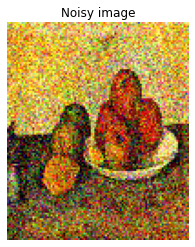

In [25]:
plt.imshow(dataset_noisy[54,:,:], cmap='gray')
plt.axis('off')
plt.title('Noisy image');

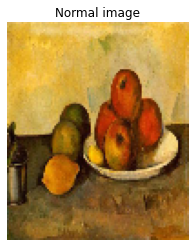

In [26]:
plt.imshow(dataset_scaled[54,:,:], cmap='gray')
plt.axis('off')
plt.title('Normal image');

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_noisy, dataset_scaled, test_size=0.2)

In [29]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

In [30]:
# ! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

# import pickle
# with open("data_painting_solution.pickle", "rb") as file:
#     (X_train_p, Y_train_p, X_test_p, Y_test_p) = pickle.load(file)

In [31]:
# X_train_p.shape, X_train.shape

In [32]:
# X_train_p[:,:,:,0].std(), X_train[:,:,:,0].std()

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [34]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [35]:
input_shape = X_train.shape[1:]
input_shape

(120, 100, 3)

In [36]:
# CODE HERE YOUR ENCODER ARCHITECTURE AND PRINT IT'S MODEL SUMMARY
encoder = Sequential(name='encoder')

encoder.add(layers.Conv2D(filters=32, kernel_size=3, input_shape=input_shape, activation='relu'))
encoder.add(layers.MaxPooling2D(2))
    
encoder.add(layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
encoder.add(layers.MaxPool2D(pool_size=(2, 2)))

encoder.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
encoder.add(layers.MaxPool2D(pool_size=(2, 2)))

encoder.add(layers.Flatten())
encoder.add(layers.Dense(latent_dimensions, activation='tanh'))

encoder.summary()
#encoder = None

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 118, 98, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 6, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0   

👉 **Test your encoder below**

In [37]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 6000)              1172768   
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 1,179,443
Trainable params: 1,179,443
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [38]:
score_baseline = np.mean(X_test[:,:,:,0].std())
score_baseline

0.30998337

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [39]:
autoencoder.compile(optimizer='adam', 
                    loss=losses.MeanSquaredError(),
                    metrics=['mae'])

In [40]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

autoencoder.fit(X_train, Y_train,
          batch_size=32,
          epochs=50,
          validation_split=0.3,
          callbacks=[es],
          verbose=0)

❓ **Plot your training and validation loss at each epoch using the cell below**

In [41]:
def plot_history(history):
    fig = plt.gcf()
    plt.plot(history.history['loss'], label = 'Train')
    plt.plot(history.history['val_loss'], label = 'Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Run also this code to save figure as jpg in path below (it's your job to ensure it works)
    plt.savefig("tests/history.jpg")
    plt.show()

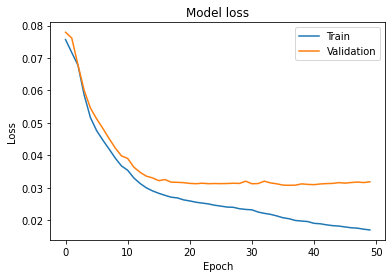

In [42]:
plot_history(autoencoder.history)

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [43]:
Y_pred = autoencoder.predict(X_test)

In [44]:
score_test = autoencoder.evaluate(X_test, X_test)
score_test

7/7 [==============================] - 1s 179ms/step - loss: 0.0563 - mae: 0.1877


[0.05634168162941933, 0.18767806887626648]

In [45]:
score_train = autoencoder.evaluate(X_train, X_train)

28/28 [==============================] - 6s 226ms/step - loss: 0.0495 - mae: 0.1770


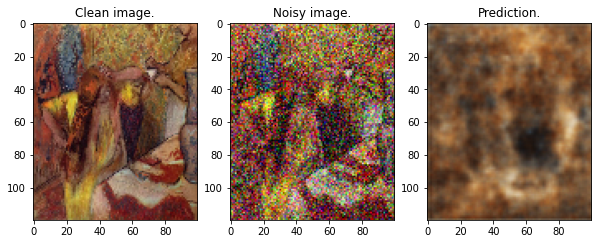

In [46]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [47]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()